In [1]:
# Import necessary librabries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from yellowbrick.regressor import PredictionError, ResidualsPlot

from sklearn.preprocessing import PowerTransformer
# from feature_engine.outlier_removers import Winsorizer

from sklearn.feature_selection import RFE

In [2]:
# Reading retailer*ppg level data
retailer_ppg_groupby = pd.read_csv("./Retailer_ppg_data.csv")

In [3]:
retailer_ppg_groupby.shape

(1356, 15)

In [4]:
retailer_ppg_groupby['Unique_key'] = retailer_ppg_groupby['Retailer']+'_'+ retailer_ppg_groupby['PPG']

In [5]:
req_comp = retailer_ppg_groupby['Unique_key'].unique()
req_comp

array(['Retailer 0_Promo.Group 20', 'Retailer 0_Promo.Group 22',
       'Retailer 0_Promo.Group 19', 'Retailer 0_Promo.Group 3',
       'Retailer 0_Promo.Group 5', 'Retailer 0_Promo.Group 6',
       'Retailer 1_Promo.Group 20', 'Retailer 1_Promo.Group 22',
       'Retailer 1_Promo.Group 19', 'Retailer 1_Promo.Group 3',
       'Retailer 1_Promo.Group 5', 'Retailer 1_Promo.Group 6'],
      dtype=object)

In [6]:
retailer_ppg_groupby.head()

,Date,Retailer,Brand,PPG,Wtd.Selling.Dist,Vol.Sales,promo_catalogue,promo_ins,display_platinum,display_gold,display_silver,display_bronze,Unique_key,Year,Month
0,2018-08-05,Retailer 0,Brand 1,Promo.Group 20,19.733333,3.71096,0.0,0.0,0.0,0.0,0.0,0.0,Retailer 0_Promo.Group 20,2018,8
1,2018-08-05,Retailer 0,Brand 1,Promo.Group 22,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,Retailer 0_Promo.Group 22,2018,8
2,2018-08-05,Retailer 0,Brand 4,Promo.Group 19,19.660000,8.85976,0.0,1.0,0.0,0.0,0.0,0.0,Retailer 0_Promo.Group 19,2018,8
3,2018-08-05,Retailer 0,Brand 4,Promo.Group 3,11.868889,10.65029,0.0,0.0,0.0,0.0,0.0,0.0,Retailer 0_Promo.Group 3,2018,8
4,2018-08-05,Retailer 0,Brand 5,Promo.Group 5,27.518182,23.34048,0.0,1.0,0.0,0.0,0.0,0.0,Retailer 0_Promo.Group 5,2018,8


In [7]:
retailer_ppg_groupby['Date'] = pd.to_datetime(retailer_ppg_groupby['Date'])
retailer_ppg_groupby['Week'] = retailer_ppg_groupby['Date'].dt.week

C:\Users\mangesh.shinde\AppData\Local\Temp\ipykernel_28524\1835666306.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  retailer_ppg_groupby['Week'] = retailer_ppg_groupby['Date'].dt.week


In [8]:
# Creating required functions


def get_comp_data(df, ppg, req_comp):
    """
    Creates dataframe with competitor of given PPG
    
    Args: Dataframe with data for all ppgs, PPG, Competitor PPG
    
    """
    
    temp_df = df[df['Unique_key']==ppg]
    print(ppg)
    for i in req_comp:
        if i == ppg:
            continue
        if i == 'NA':
            return temp_df
        comp_df = df[df['Unique_key']==i]
        comp_str = i
        rename_dict = {"Wtd.Selling.Dist":comp_str+"_Wtd.Selling.Dist", "promo_catalogue":comp_str+"_promo_catalogue",
                       "promo_ins":comp_str+"_promo_ins", "display_platinum":comp_str+"_display_platinum",
                       "display_silver":comp_str+"_display_silver","display_bronze":comp_str+"_display_bronze"
                      }
        
        comp_df = comp_df.rename(columns=rename_dict)
        
        temp_df = temp_df.merge(comp_df[['Date',comp_str+"_Wtd.Selling.Dist", comp_str+"_promo_catalogue",
            comp_str+"_promo_ins", comp_str+"_display_platinum", comp_str+"_display_silver",comp_str+"_display_bronze"]], 
                                on =['Date'], how ='left')
        
    return temp_df


def seasonal_index(ppg_df):
    """
    Calculate seasonality at of Vol.Sales at weekly level for each PPG at retailer level
    Args: Retailer*ppg level Dataframe 
    
    Output: Dataframe with seasonal index
    """
    df= ppg_df.groupby(['Year','Week'], as_index=False)['Vol.Sales'].sum()
    df_1 = df.groupby(['Year'], as_index=False)['Vol.Sales'].mean()
    df_1.rename(columns={'Vol.Sales':'Avg_weekly_sales'}, inplace=True)
    df_2 = df.merge(df_1, on ='Year', how='left')
    # df_2 = ppg3_0_df.merge(df_1, on = ['Year','Month'], how = 'left')
    df_2['Seasonal_index'] = df_2['Vol.Sales']/df_2['Avg_weekly_sales']
    df_3 = df_2[['Year','Week','Seasonal_index']]
    df_3 = df_3.groupby('Week',as_index = False)['Seasonal_index'].mean()
    
    df_4 = ppg_df.merge(df_3, on =['Week'], how ='left')
    
    return df_4        

# Create function for VIF calculation

def vif_calculation(df, thres = 10):
    """
    Excludes features with vif higher than the specified threshold.

    Args:
        df (pd.DataFrame): A DataFrame containing features and its values
        threshold (float): The significance level (default is 10).

    Returns:
        pd.DataFrame: A modified DataFrame with excluded features.
    """
    x_vif = df.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
    y = df['Vol.Sales']


    while True:
        Cols = range(x_vif.shape[1])

        vif = np.array([variance_inflation_factor(x_vif.values, i) for i in Cols])
        if all(vif < thres):
            break
        else:
            Cols = np.delete(Cols,np.argmax(vif))
            x_vif = x_vif.iloc[:,Cols]
            
    return x_vif


def run_OLS(x, y):
    """
    Run OLS on given data
    
    Args: Features(x) & target variable(y)
    
    Ouptut: Model Result
    """

    # adding the constant term
    x = sm.add_constant(x)

    # performing the regression
    # and fitting the model
    result = sm.OLS(y, x).fit()

    return result

def exclude_high_p_values(df, threshold=0.05):
    """
    Excludes features with p-values higher than the specified threshold.

    Args:
        df (pd.DataFrame): A DataFrame containing features and their p-values.
        threshold (float): The significance level (default is 0.05).

    Returns:
        pd.DataFrame: A modified DataFrame with excluded features.
    """
        
    excluded_features = df[df['pvalue'] > threshold]['feature'].tolist()
    filtered_df = df[~df['feature'].isin(excluded_features)]

    return filtered_df



def ols_with_feature_selection(df, ppg_retailer:str, threshold=0.05, thres=10):
    """
    Create model summary of ols with feature selection
    
    Args: 1.PPG Dataframe (df), 2. threshold for p value (threshold), 3. threshold for vif (thres)
    4. ppg_retailer : name of ppg & retailer
    
    Output: Final model summary 
    """
    x_vif = vif_calculation(df,thres=thres)
    x = x_vif

    y = df['Vol.Sales']
    result = run_OLS(x,y)

    pVals = result.pvalues
    pValue_df = pd.DataFrame(pVals, columns=['pvalue']).reset_index(names = ['feature'])

    pvals_filtered = exclude_high_p_values(pValue_df, threshold=threshold)

    fixed_features = ['promo_catalogue', 'promo_ins', 'display_platinum','display_gold', 'display_silver', 'display_bronze','Seasonal_index']
    req_features = list(set(pvals_filtered['feature']) | set(fixed_features))

    req_features = [x for x in req_features if x != 'const'] 
    
    print(req_features)
    
    x = df[req_features]
    y = df['Vol.Sales']
    
    # Run OLS model
    result = run_OLS(x,y)
    # print model summary
    print(result.summary())
    
    # saving model summary
    result_df = pd.DataFrame(result.params, columns=['Coeff']).reset_index(names='Features')
    result_df.to_csv(f"../model_results/{ppg_retailer}_summary.csv", index=False)

    return result
    
    
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Val Sales', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

### PPG3_Retailer_0

In [9]:
ppg3_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 3', req_comp=req_comp)
ppg3_0_df_seasonality = seasonal_index(ppg3_0_df)

Retailer 0_Promo.Group 3


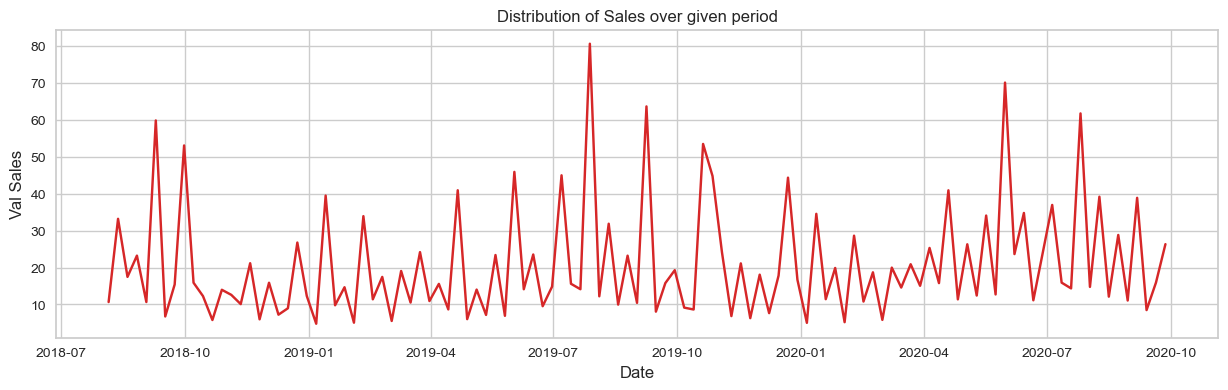

In [10]:
plot_df(ppg3_0_df_seasonality, x=ppg3_0_df_seasonality['Date'], y=ppg3_0_df_seasonality['Vol.Sales'], title='Distribution of Sales over given period')

In [11]:
# Create OLS without feature selection
x = ppg3_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg3_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_3_0 = ols_with_feature_selection(ppg3_0_df_seasonality, ppg_retailer='ppg3_0')

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     19.72
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           8.05e-23
Time:                        13:02:18   Log-Likelihood:                -298.33
No. Observations:                 113   AIC:                             708.7
Df Residuals:                      57   BIC:                             861.4
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'Retailer 1_Promo.Group 22_display_bronze', 'display_silver', 'promo_catalogue', 'Retailer 0_Promo.Group 20_display_platinum', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     116.0
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           8.79e-50
Time:                        13:02:29   Log-Likelihood:                -331.49
No. Observations:                 113   AIC:                             683.0
Df Residuals:                     103   BIC:                             710.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                       

### PPG3_Retailer_1

In [12]:
ppg3_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 3', req_comp=req_comp)
ppg3_1_df_seasonality = seasonal_index(ppg3_1_df) # Calculate seasonal index

Retailer 1_Promo.Group 3


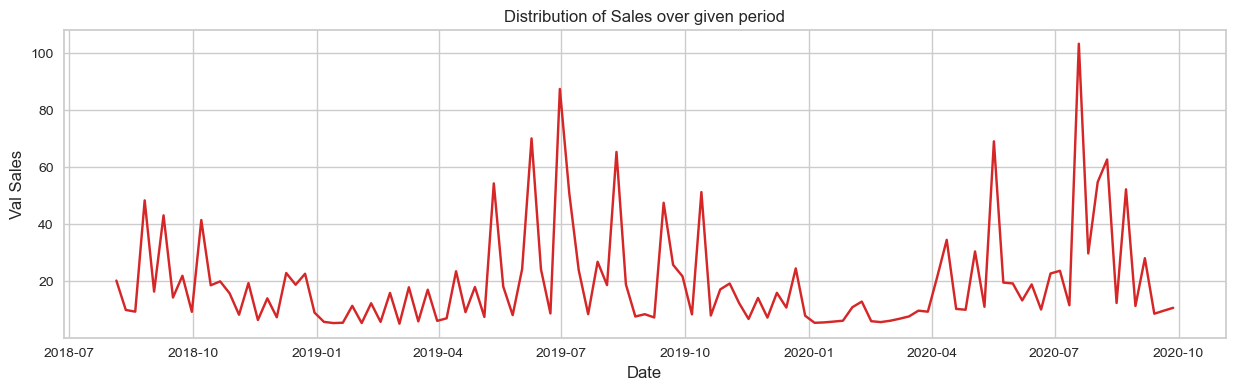

In [13]:
# Plot graph of seasonality
plot_df(ppg3_1_df_seasonality, x=ppg3_1_df_seasonality['Date'], y=ppg3_1_df_seasonality['Vol.Sales'], title='Distribution of Sales over given period')

In [14]:
# Create OLS without feature selection
x = ppg3_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg3_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_3_1 = ols_with_feature_selection(ppg3_0_df_seasonality,ppg_retailer='ppg3_1')

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     8.779
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           3.22e-14
Time:                        13:02:30   Log-Likelihood:                -360.71
No. Observations:                 113   AIC:                             833.4
Df Residuals:                      57   BIC:                             986.2
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'Retailer 1_Promo.Group 22_display_bronze', 'display_silver', 'promo_catalogue', 'Retailer 0_Promo.Group 20_display_platinum', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     116.0
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           8.79e-50
Time:                        13:02:41   Log-Likelihood:                -331.49
No. Observations:                 113   AIC:                             683.0
Df Residuals:                     103   BIC:                             710.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                       

### PPG5_Retailer_0

Retailer 0_Promo.Group 5


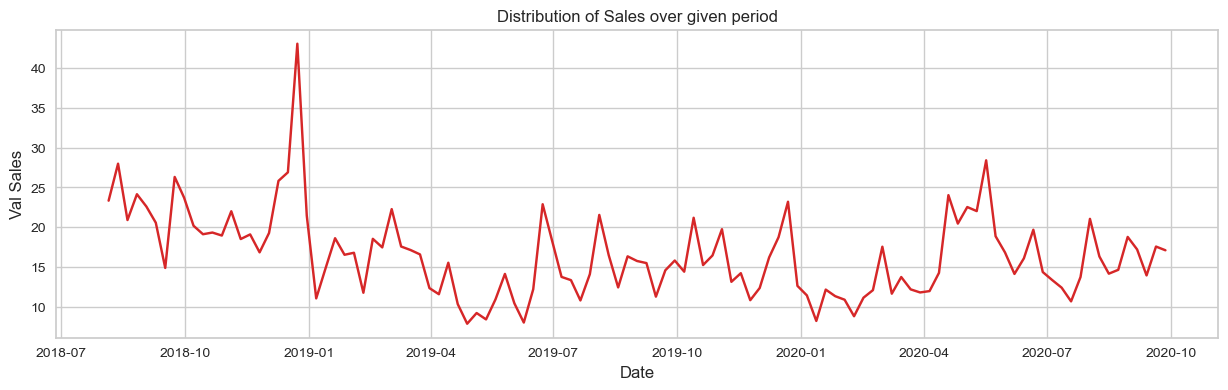

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     11.56
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           3.45e-17
Time:                        13:13:39   Log-Likelihood:                -209.07
No. Observations:                 113   AIC:                             528.1
Df Residuals:                      58   BIC:                             678.1
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'display_silver', 'Retailer 0_Promo.Group 22_Wtd.Selling.Dist', 'Retailer 0_Promo.Group 19_display_bronze', 'Retailer 0_Promo.Group 22_display_bronze', 'promo_catalogue', 'display_bronze', 'Retailer 0_Promo.Group 22_promo_ins', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     38.49
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           3.00e-26
Time:                        13:13:50   Log-Likelihood:                -276.51
No. Observations:                 113   AIC:                             569.0
Df Residuals:                     105   BIC:                             590.8
Df Model:                           7                                   

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [44]:
ppg5_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 5', req_comp=req_comp)
ppg5_0_df_seasonality = seasonal_index(ppg5_0_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg5_0_df_seasonality, 
        x=ppg5_0_df_seasonality['Date'], y=ppg5_0_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg5_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg5_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_5_0 = ols_with_feature_selection(ppg5_0_df_seasonality,ppg_retailer='ppg5_0', thres = 10)

### PPG5_Retailer_1

Retailer 1_Promo.Group 5


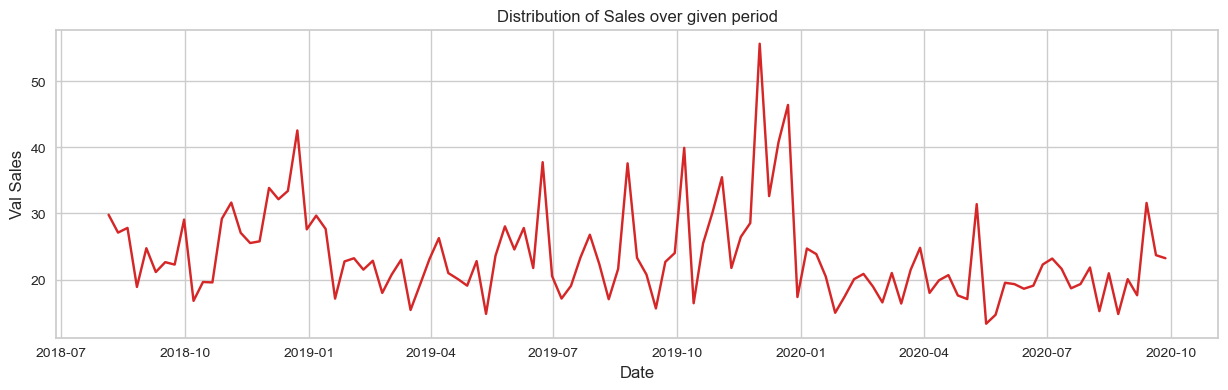

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     9.798
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           2.56e-15
Time:                        13:13:27   Log-Likelihood:                -247.76
No. Observations:                 113   AIC:                             607.5
Df Residuals:                      57   BIC:                             760.2
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'display_silver', 'promo_catalogue', 'Retailer 0_Promo.Group 20_promo_ins', 'display_bronze', 'Retailer 0_Promo.Group 3_promo_ins', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     39.69
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           2.84e-28
Time:                        13:13:38   Log-Likelihood:                -301.29
No. Observations:                 113   AIC:                             620.6
Df Residuals:                     104   BIC:                             645.1
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
          

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [43]:
ppg5_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 5', req_comp=req_comp)
ppg5_1_df_seasonality = seasonal_index(ppg5_1_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg5_1_df_seasonality, 
        x=ppg5_1_df_seasonality['Date'], y=ppg5_1_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg5_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg5_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_5_1 = ols_with_feature_selection(ppg5_1_df_seasonality,ppg_retailer='ppg5_1', thres = 10)

### PPG6_Retailer_0

Retailer 0_Promo.Group 6


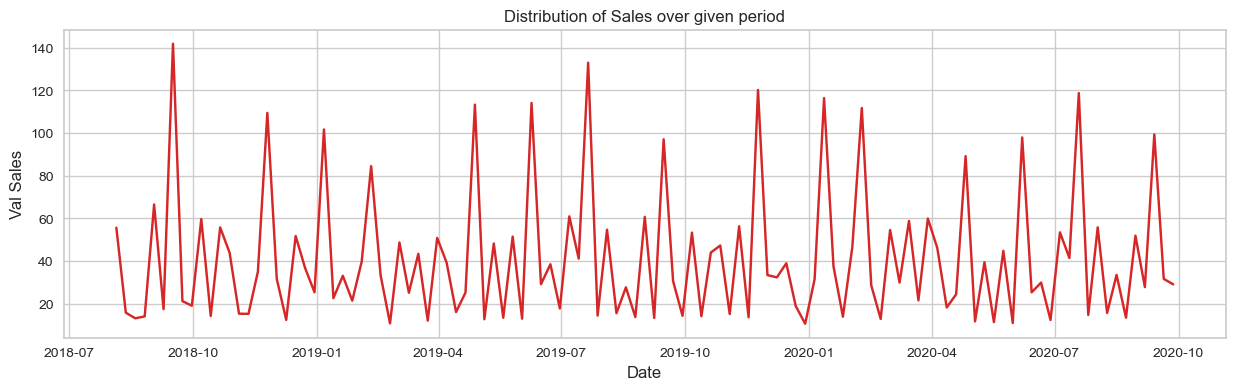

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     27.54
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.28e-26
Time:                        13:03:12   Log-Likelihood:                -361.54
No. Observations:                 113   AIC:                             835.1
Df Residuals:                      57   BIC:                             987.8
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'display_silver', 'promo_catalogue', 'display_bronze', 'Retailer 0_Promo.Group 22_promo_ins', 'display_gold', 'Retailer 1_Promo.Group 3_display_bronze', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     170.9
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           9.41e-58
Time:                        13:03:25   Log-Likelihood:                -392.53
No. Observations:                 113   AIC:                             805.1
Df Residuals:                     103   BIC:                             832.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
     

In [17]:
ppg6_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 6', req_comp=req_comp)
ppg6_0_df_seasonality = seasonal_index(ppg6_0_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg6_0_df_seasonality, 
        x=ppg6_0_df_seasonality['Date'], y=ppg6_0_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg6_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg6_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_6_0 = ols_with_feature_selection(ppg6_0_df_seasonality, ppg_retailer='ppg6_0')

### PPG6_Retailer_1

Retailer 1_Promo.Group 6


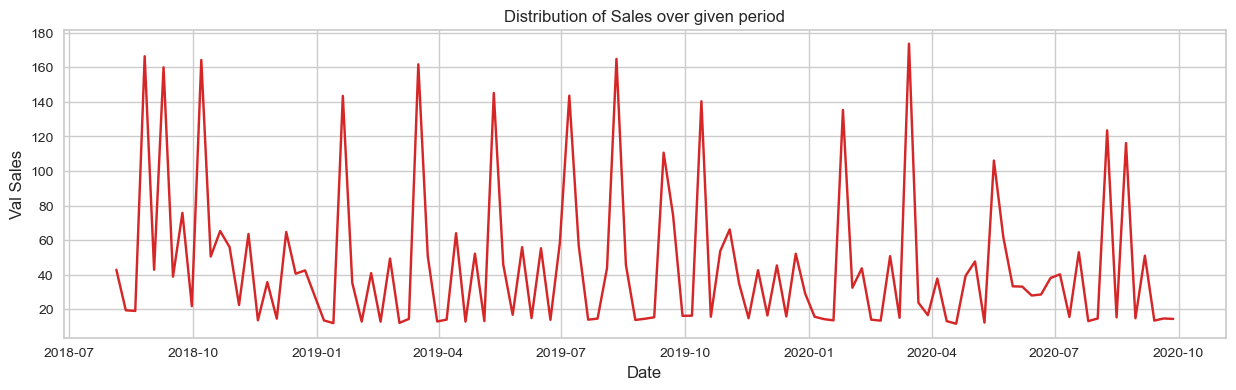

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     12.54
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           6.98e-18
Time:                        13:03:26   Log-Likelihood:                -438.64
No. Observations:                 113   AIC:                             989.3
Df Residuals:                      57   BIC:                             1142.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['Retailer 1_Promo.Group 3_display_silver', 'display_platinum', 'Seasonal_index', 'Retailer 1_Promo.Group 22_display_bronze', 'Retailer 1_Promo.Group 20_promo_catalogue', 'display_silver', 'promo_catalogue', 'Retailer 1_Promo.Group 20_display_platinum', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     48.93
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.93e-34
Time:                        13:03:38   Log-Likelihood:                -484.72
No. Observations:                 113   AIC:                             991.4
Df Residuals:                     102   BIC:                             1021.
Df Model:                          10                              

In [18]:
ppg6_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 6', req_comp=req_comp)
ppg6_1_df_seasonality = seasonal_index(ppg6_1_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg6_1_df_seasonality, 
        x=ppg6_1_df_seasonality['Date'], y=ppg6_1_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg6_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg6_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_6_1 = ols_with_feature_selection(ppg6_1_df_seasonality, ppg_retailer='ppg6_1')

### PPG19_Retailer_0

Retailer 0_Promo.Group 19


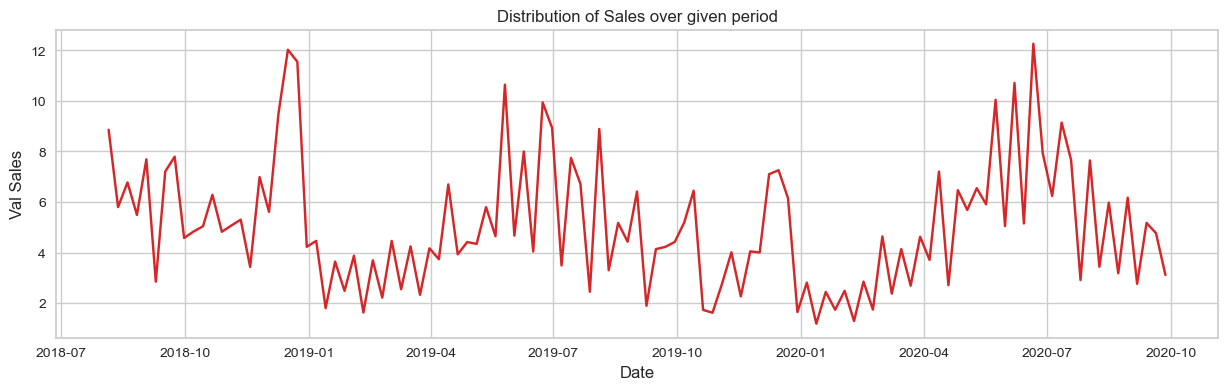

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     26.99
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.07e-26
Time:                        13:03:39   Log-Likelihood:                -78.933
No. Observations:                 113   AIC:                             267.9
Df Residuals:                      58   BIC:                             417.9
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Retailer 1_Promo.Group 3_promo_ins', 'Seasonal_index', 'display_silver', 'Retailer 0_Promo.Group 22_Wtd.Selling.Dist', 'promo_catalogue', 'display_bronze', 'Retailer 0_Promo.Group 22_promo_ins', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     213.3
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           8.66e-57
Time:                        13:03:51   Log-Likelihood:                -118.06
No. Observations:                 113   AIC:                             250.1
Df Residuals:                     106   BIC:                             269.2
Df Model:                           6                                         
Covariance Type:            nonrobust      

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [19]:
ppg19_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 19', req_comp=req_comp)
ppg19_0_df_seasonality = seasonal_index(ppg19_0_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg19_0_df_seasonality, 
        x=ppg19_0_df_seasonality['Date'], y=ppg19_0_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg19_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg19_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_19_0 = ols_with_feature_selection(ppg19_0_df_seasonality, ppg_retailer='ppg19_0')

### PPG19_Retailer_1

Retailer 1_Promo.Group 19


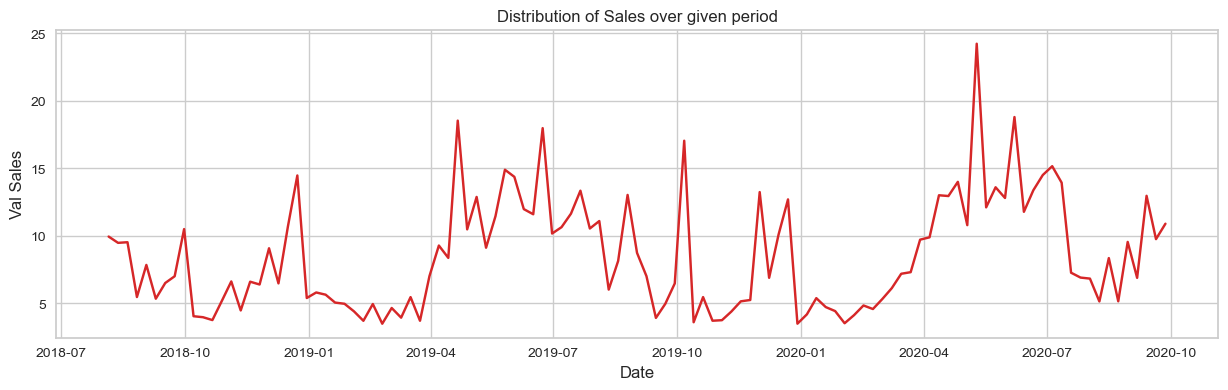

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     12.64
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           5.81e-18
Time:                        13:03:52   Log-Likelihood:                -174.67
No. Observations:                 113   AIC:                             461.3
Df Residuals:                      57   BIC:                             614.1
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['Retailer 0_Promo.Group 20_display_silver', 'Retailer 1_Promo.Group 6_promo_catalogue', 'display_platinum', 'Seasonal_index', 'display_silver', 'Retailer 0_Promo.Group 22_Wtd.Selling.Dist', 'promo_catalogue', 'display_bronze', 'display_gold', 'Retailer 1_Promo.Group 3_display_bronze', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     58.96
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           7.35e-38
Time:                        13:04:03   Log-Likelihood:                -212.29
No. Observations:                 113   AIC:                             446.6
Df Residuals:                     102   BIC:                             476.6
Df Model:                          10                               

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [20]:
ppg19_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 19', req_comp=req_comp)
ppg19_1_df_seasonality = seasonal_index(ppg19_1_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg19_1_df_seasonality, 
        x=ppg19_1_df_seasonality['Date'], y=ppg19_1_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg19_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg19_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_19_1 = ols_with_feature_selection(ppg19_1_df_seasonality, ppg_retailer='ppg19_1')

### PPG20_Retailer_0

Retailer 0_Promo.Group 20


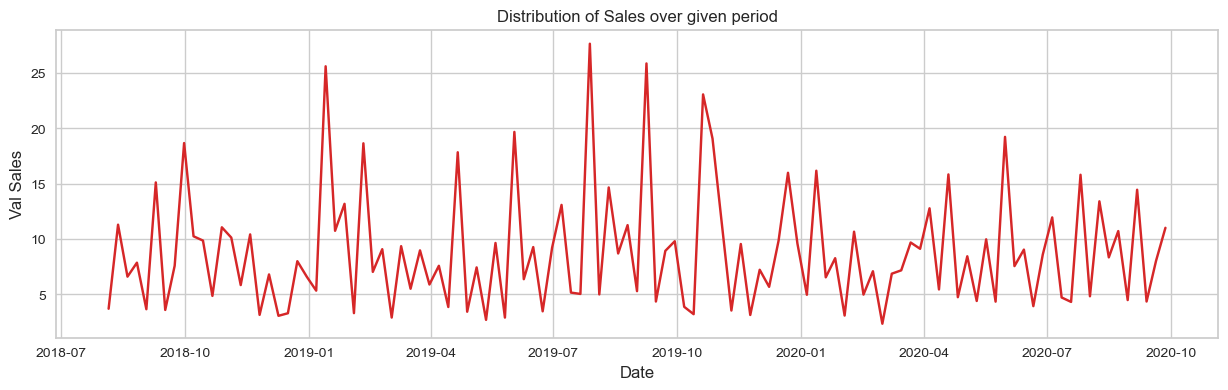

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     13.69
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           8.17e-19
Time:                        13:04:04   Log-Likelihood:                -198.73
No. Observations:                 113   AIC:                             509.5
Df Residuals:                      57   BIC:                             662.2
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Seasonal_index', 'display_silver', 'promo_catalogue', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     88.40
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           4.26e-41
Time:                        13:04:15   Log-Likelihood:                -239.60
No. Observations:                 113   AIC:                             495.2
Df Residuals:                     105   BIC:                             517.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--

In [21]:
ppg20_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 20', req_comp=req_comp)
ppg20_0_df_seasonality = seasonal_index(ppg20_0_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg20_0_df_seasonality, 
        x=ppg20_0_df_seasonality['Date'], y=ppg20_0_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg20_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg20_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_20_0 = ols_with_feature_selection(ppg20_0_df_seasonality, ppg_retailer='ppg20_0')

### PPG20_Retailer_1

Retailer 1_Promo.Group 20


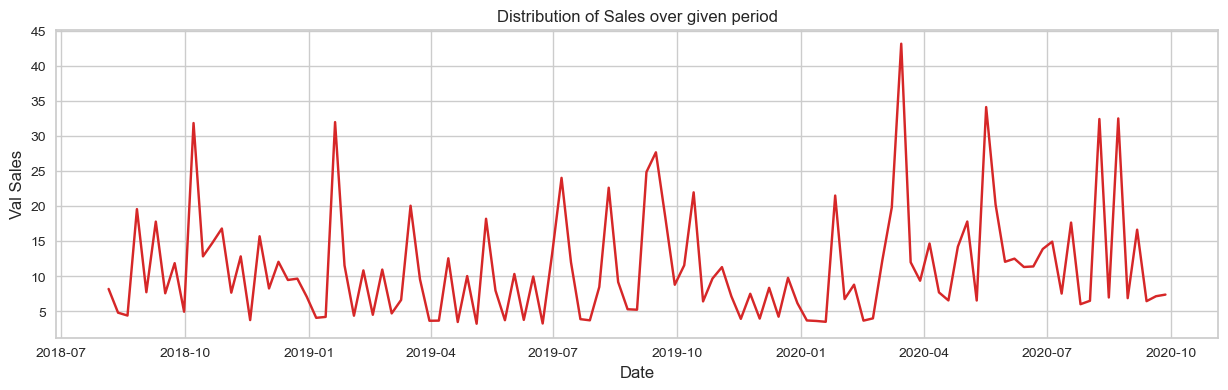

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     8.964
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           2.00e-14
Time:                        13:12:38   Log-Likelihood:                -264.42
No. Observations:                 113   AIC:                             640.8
Df Residuals:                      57   BIC:                             793.6
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['Retailer 1_Promo.Group 6_promo_catalogue', 'Retailer 0_Promo.Group 3_Wtd.Selling.Dist', 'display_platinum', 'Seasonal_index', 'display_silver', 'promo_catalogue', 'display_bronze', 'display_gold', 'Retailer 0_Promo.Group 6_promo_catalogue', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     35.15
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.47e-27
Time:                        13:12:49   Log-Likelihood:                -313.17
No. Observations:                 113   AIC:                             646.3
Df Residuals:                     103   BIC:                             673.6
Df Model:                           9                                         
Covariance Type:            nonro

In [40]:
ppg20_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 20', req_comp=req_comp)
ppg20_1_df_seasonality = seasonal_index(ppg20_1_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg20_1_df_seasonality, 
        x=ppg20_1_df_seasonality['Date'], y=ppg20_1_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg20_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg20_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_20_1 = ols_with_feature_selection(ppg20_1_df_seasonality, ppg_retailer='ppg20_1', thres = 12)

### PPG22_Retailer_0

Retailer 0_Promo.Group 22


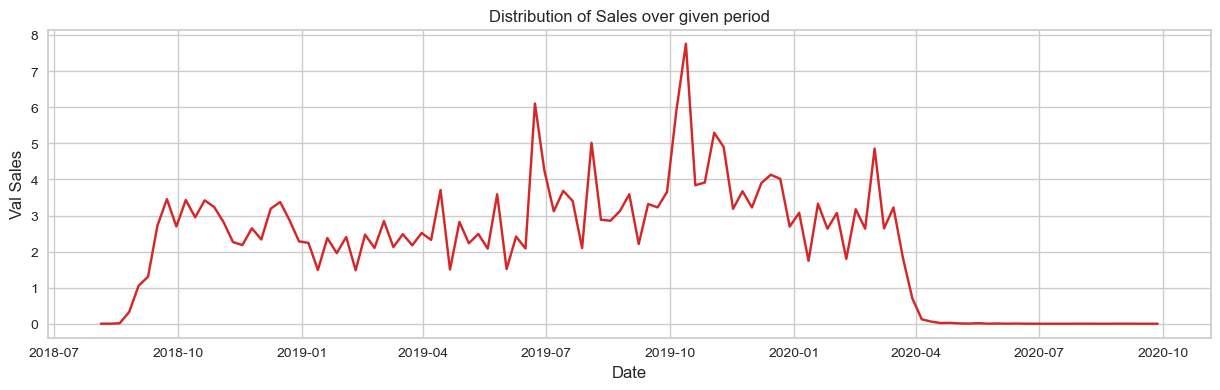

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     10.96
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.26e-16
Time:                        13:11:22   Log-Likelihood:                -78.881
No. Observations:                 113   AIC:                             267.8
Df Residuals:                      58   BIC:                             417.8
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


['display_platinum', 'Retailer 0_Promo.Group 3_Wtd.Selling.Dist', 'Seasonal_index', 'Retailer 0_Promo.Group 5_promo_catalogue', 'Wtd.Selling.Dist', 'display_silver', 'promo_catalogue', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     47.98
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           4.93e-28
Time:                        13:11:33   Log-Likelihood:                -141.25
No. Observations:                 113   AIC:                             296.5
Df Residuals:                     106   BIC:                             315.6
Df Model:                           6                                         
Covariance Type:            nonrobust                    

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [36]:
ppg22_0_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 0_Promo.Group 22', req_comp=req_comp)
ppg22_0_df_seasonality = seasonal_index(ppg22_0_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg22_0_df_seasonality, 
        x=ppg22_0_df_seasonality['Date'], y=ppg22_0_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg22_0_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg22_0_df_seasonality['Vol.Sales']

result = run_OLS(x,y)
 
# printing the summary table
print(result.summary())

final_result_22_0 = ols_with_feature_selection(ppg22_0_df_seasonality, ppg_retailer='ppg22_0',thres = 12)

### PPG22_Retailer_1

Retailer 1_Promo.Group 22


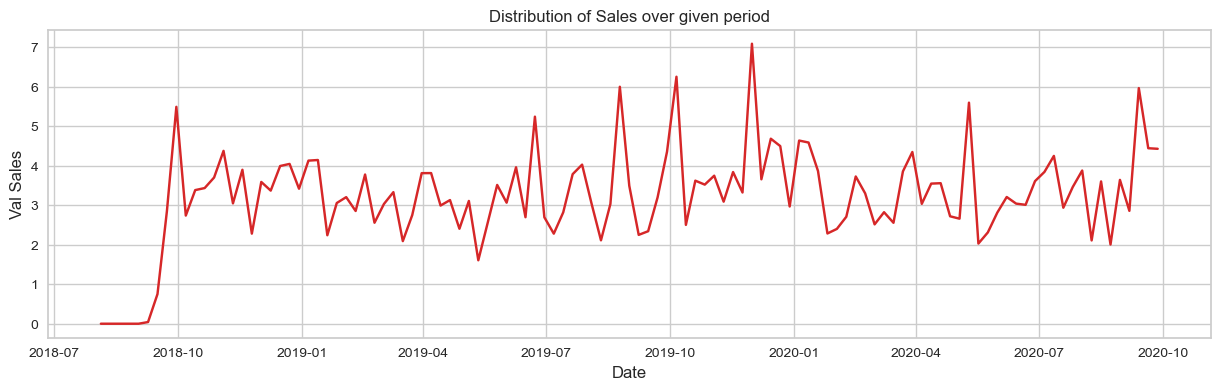

                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     22.85
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.76e-24
Time:                        13:09:46   Log-Likelihood:                -6.3726
No. Observations:                 113   AIC:                             124.7
Df Residuals:                      57   BIC:                             277.5
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\ProgramData\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


['Retailer 1_Promo.Group 6_promo_catalogue', 'Retailer 0_Promo.Group 3_Wtd.Selling.Dist', 'display_platinum', 'Retailer 1_Promo.Group 19_display_bronze', 'Seasonal_index', 'display_silver', 'promo_catalogue', 'Retailer 1_Promo.Group 20_promo_ins', 'display_bronze', 'display_gold', 'promo_ins']
                            OLS Regression Results                            
Dep. Variable:              Vol.Sales   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.680
Method:                 Least Squares   F-statistic:                     24.76
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           4.62e-23
Time:                        13:09:57   Log-Likelihood:                -114.05
No. Observations:                 113   AIC:                             250.1
Df Residuals:                     102   BIC:                             280.1
Df Model:                          10                                    

C:\ProgramData\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1934: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


In [32]:
ppg22_1_df = get_comp_data(retailer_ppg_groupby, ppg='Retailer 1_Promo.Group 22', req_comp=req_comp)
ppg22_1_df_seasonality = seasonal_index(ppg22_1_df) # Calculate seasonal index

# Plot graph of seasonality
plot_df(ppg22_1_df_seasonality, 
        x=ppg22_1_df_seasonality['Date'], y=ppg22_1_df_seasonality['Vol.Sales'], 
        title='Distribution of Sales over given period'
       )

# Create OLS without feature selection
x = ppg22_1_df_seasonality.drop(columns = ['Date', 'Retailer', 'Brand', 'PPG','Vol.Sales','Unique_key', 'Year', 'Month','Week'])
y = ppg22_1_df_seasonality['Vol.Sales']

result = run_OLS(x,y)

# printing the summary table
print(result.summary())

final_result_22_1 = ols_with_feature_selection(ppg22_1_df_seasonality,ppg_retailer='ppg22_1', thres = 10)

In [107]:
# Creating model summary of all models in one file.
import glob
path = r"./model_results/*.csv"

model_summary = pd.DataFrame()
for fname in glob.glob(path):
#     print(fname)
    df = pd.read_csv(fname)
    df_transpose = df.transpose()
    headers = df_transpose.iloc[0].values
    df_transpose.columns = headers
    df_transpose.drop(index='Features', axis=0, inplace=True)
    ppg_name = "_".join(fname.split('\\')[1].split("_")[:-1])
    df_transpose['PPG'] = ppg_name
    model_summary = pd.concat([model_summary,df_transpose],axis=0)

In [110]:
model_summary = model_summary.reset_index(drop=True)

In [112]:
model_summary = model_summary[['PPG','const', 'Seasonal_index', 'promo_catalogue','promo_ins',
       'display_platinum', 'display_gold', 'display_silver','display_bronze',
       'Retailer 1_Promo.Group 3_promo_ins','Retailer 0_Promo.Group 22_Wtd.Selling.Dist',
       'Retailer 0_Promo.Group 22_promo_ins','Retailer 0_Promo.Group 20_display_silver',
       'Retailer 1_Promo.Group 6_promo_catalogue',
       'Retailer 1_Promo.Group 3_display_bronze',
       'Retailer 0_Promo.Group 3_Wtd.Selling.Dist',
       'Retailer 0_Promo.Group 6_promo_catalogue',
       'Retailer 0_Promo.Group 5_promo_catalogue', 'Wtd.Selling.Dist',
       'Retailer 1_Promo.Group 19_display_bronze',
       'Retailer 1_Promo.Group 20_promo_ins',
       'Retailer 1_Promo.Group 22_display_bronze',
       'Retailer 0_Promo.Group 20_display_platinum',
       'Retailer 0_Promo.Group 19_display_bronze',
       'Retailer 0_Promo.Group 22_display_bronze',
       'Retailer 0_Promo.Group 20_promo_ins',
       'Retailer 0_Promo.Group 3_promo_ins',
       'Retailer 1_Promo.Group 3_display_silver',
       'Retailer 1_Promo.Group 20_promo_catalogue',
       'Retailer 1_Promo.Group 20_display_platinum']]

In [114]:
# Saving Model Summary file
model_summary.to_csv('./model_results/model_summary.csv', index=False)

In [120]:
for fname in glob.glob(path)[:1]:
    print(fname)
    df = pd.read_csv(fname)

./model_results\model_summary.csv


In [154]:
ppg_list = list(df['PPG'])

df_name_list = [ppg19_0_df_seasonality,
 ppg19_1_df_seasonality,
 ppg20_0_df_seasonality,
 ppg20_1_df_seasonality,
 ppg22_0_df_seasonality,
 ppg22_1_df_seasonality,
 ppg3_0_df_seasonality,
 ppg3_1_df_seasonality,
 ppg5_0_df_seasonality,
 ppg5_1_df_seasonality,
 ppg6_0_df_seasonality,
 ppg6_1_df_seasonality]

In [172]:
# Calcuating contribution of each feature in sales volume

for ppg, j in zip(ppg_list,df_name_list):
    ppg_df = j.copy()
    df_2 = pd.DataFrame()
    df_1 = df[df['PPG']==ppg].reset_index(drop=True)
    df_1 = df_1.dropna(axis=1)
    for i in df_1.columns:
        if i=='PPG' or i == 'const':
            continue
        else:
            df_2[i] = df_1[i][0]*ppg_df[i]   

        df_2['const'] = df_1['const'][0]
        df_2['PPG'] = ppg
        df_2['Date'] = ppg_df['Date']
        df_2['Year'] = ppg_df['Year']
        df_2['Month'] = ppg_df['Month']
        df_2['Week'] = ppg_df['Week']
        df_2['Vol.Sales'] = ppg_df['Vol.Sales']
        req_cols = [x for x in df_2.columns if x not in ['PPG','Date','Year','Month', 'Week', 'Vol.Sales']]
    
    df_2['Vol.Sales_pred'] = np.sum(df_2[req_cols], axis = 1)
    # Saving files 
    df_2.to_csv(f"./contribution/{ppg}_contribution.csv", index=False)

In [282]:
# Calculating Monthly contribution

path_1 = r"./contribution//*.csv"
for fname in glob.glob(path_1):
    ppg = "_".join(fname.split("\\")[-1].split("_")[:-2])
    df = pd.read_csv(fname)
    req_cols_1 = [x for x in df.columns if x not in ['PPG','Date','Year','Month', 'Week']]
    yearly_contri_df = df.groupby(['PPG','Year','Month'], as_index=False)[req_cols_1].sum()
    yearly_contri_df.to_csv(f"./contribution/monthly_contri/{ppg}.csv", index=False)
    

In [312]:
#### Calculating monthly percentage distribution

path_2 = r"./contribution//monthly_contri//*.csv"
for fname in glob.glob(path_2):
    print(fname)
    ppg = fname.split("\\")[-1]
    df = pd.read_csv(fname)
    req_cols_2 = [x for x in df.columns if x not in ['PPG','Date','Year','Month','Vol.Sales','Vol.Sales_pred']]
    for i in req_cols_2:
        df[f'perc {i}'] = df[i]/df['Vol.Sales']*100
    df = df.drop(columns=req_cols_2)
    df.to_csv(f"./contribution/monthly_percnt_contri/{ppg}_contribution.csv")

./contribution//monthly_contri\ppg19_0.csv
./contribution//monthly_contri\ppg19_1.csv
./contribution//monthly_contri\ppg20_0.csv
./contribution//monthly_contri\ppg20_1.csv
./contribution//monthly_contri\ppg22_0.csv
./contribution//monthly_contri\ppg22_1.csv
./contribution//monthly_contri\ppg3_0.csv
./contribution//monthly_contri\ppg3_1.csv
./contribution//monthly_contri\ppg5_0.csv
./contribution//monthly_contri\ppg5_1.csv
./contribution//monthly_contri\ppg6_0.csv
./contribution//monthly_contri\ppg6_1.csv
